In [ ]:
#Libraries used
import torch
from skimage import io, transform
from skimage.color import rgb2gray
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from google.colab import drive
from torchvision.transforms import RandomRotation, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter
from PIL import Image

In [ ]:
#Connecting to drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class SatteliteDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.images = [f"image_part_{i+1:03}.jpg" for i in range(len(os.listdir(image_dir)))]
        self.masks = [f"image_part_{i+1:03}.png" for i in range(len(os.listdir(mask_dir)))]
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transformations = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):

      image_path = os.path.join(self.image_dir, f"image_part_{index+1:03}.jpg")
      image = io.imread(image_path)

      mask_path = os.path.join(self.mask_dir, f"image_part_{index+1:03}.png")
      mask = io.imread(mask_path)


      if self.transformations:
        image = self.transformations(image)
        mask = self.transformations(mask)

      return image, mask


In [ ]:
x_transform = transforms.Compose([
              transforms.ToPILImage(),
              transforms.Resize((300, 300)),
              RandomRotation(30),
              RandomHorizontalFlip(p=0.5),  #randomly flip the image horizontally with a 50% chance
              RandomVerticalFlip(p=0.5),  #randomly flip the image vertically with a 50% chance
              ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
              #transforms.ToTensor()
          ])

In [ ]:
dataset = SatteliteDataset(image_dir='/content/drive/MyDrive/sattelite_dataset/images/',
                           mask_dir='/content/drive/MyDrive/sattelite_dataset/annotations/',
                           transform= x_transform)



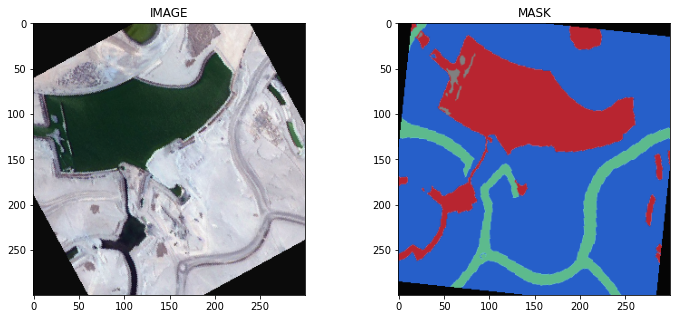

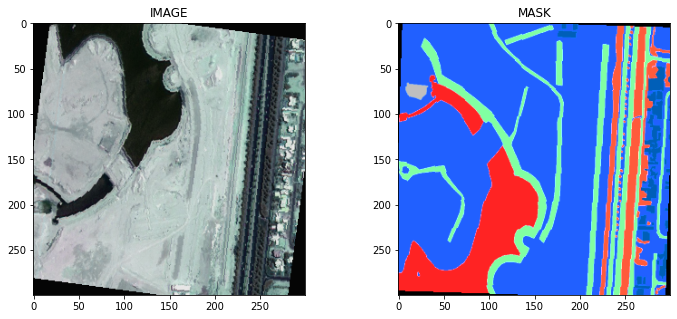

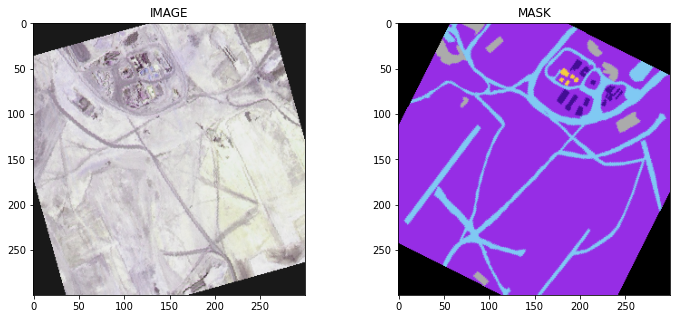

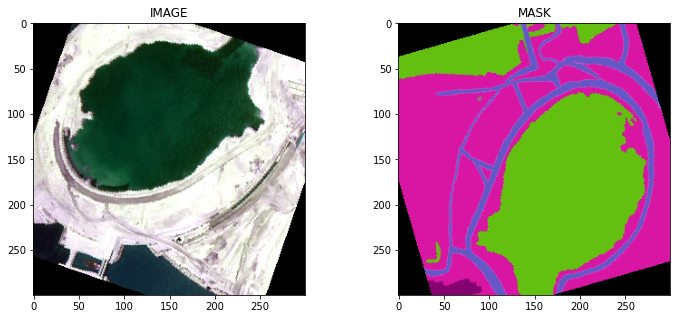

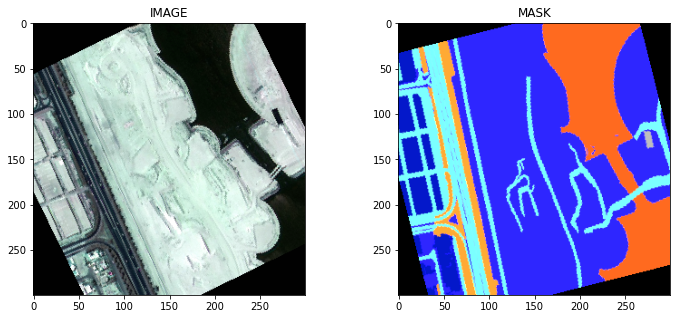

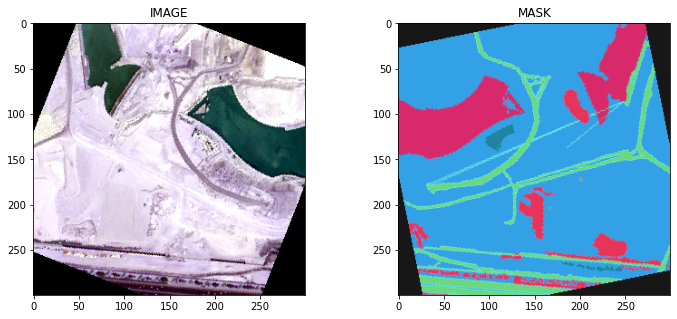

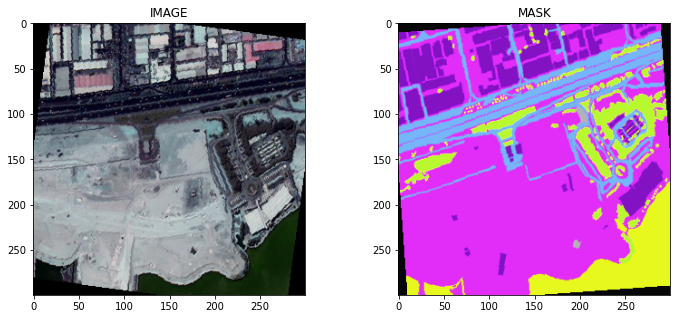

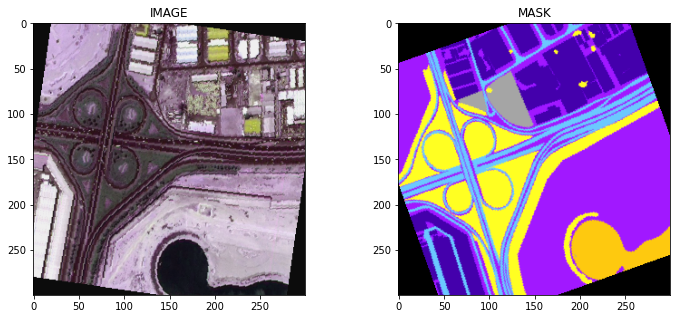

FileNotFoundError: ignored

In [ ]:
import matplotlib.pyplot as plt


dataset = SatteliteDataset(image_dir='/content/drive/MyDrive/sattelite_dataset/images/',
                           mask_dir='/content/drive/MyDrive/sattelite_dataset/annotations/',
                           transform= x_transform)


for i in range(len(dataset)):
    image, mask = dataset[i+1]

    #image_np = image.numpy()
    #mask_np = mask.numpy()

    #img_reshaped = image_np.reshape(image_np.shape[:])
    #mask_reshaped = mask_np.reshape(mask_np.shape[:])

    fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(12, 5))

    axis1.imshow(image)
    axis1.set_title("IMAGE")

    axis2.imshow(mask)
    axis2.set_title("MASK")

    plt.show()

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)
print(dataloader)



In [ ]:
x_transform = transforms.Compose([
              transforms.ToPILImage(),
              transforms.Resize((500, 500)),
              RandomRotation(30),
              RandomHorizontalFlip(p=0.5),  #randomly flip the image horizontally with a 50% chance
              RandomVerticalFlip(p=0.5),  #randomly flip the image vertically with a 50% chance
              ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
              transforms.ToTensor()
          ])

In [ ]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )


class UNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 3, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

In [ ]:
# Libraries used
import torch
from skimage import io, transform
from skimage.color import rgb2gray
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from google.colab import drive
from torchvision.transforms import RandomRotation, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter

# Define the data transformations
transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Initialize the dataset and dataloader
dataset = SatteliteDataset(image_dir='/content/drive/MyDrive/sattelite_dataset/images/',
                           mask_dir='/content/drive/MyDrive/sattelite_dataset/annotations/', transform=transformations)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

model = UNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.BCEWithLogitsLoss()

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        images, masks = data
        if masks is None:
            continue
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {running_loss/len(dataloader)}")




Epoch 1 loss: -94.26642449200153
Epoch 2 loss: -2714495.156640625
Epoch 3 loss: -2582399275.2
Epoch 4 loss: -392662811033.6
Epoch 5 loss: -29624174064435.2
Epoch 6 loss: -965841085320396.8
Epoch 7 loss: -2.98881606746112e+16
Epoch 8 loss: -3.097969574281216e+17


KeyboardInterrupt: ignored